# A Study on Gradient Boosting Algorithms and Hyperparameter Optimization using Optuna

Undergraduate Thesis submitted to the Undergraduate Course in Mechatronics Engineering from São Carlos School of Engineering, University of São Paulo – EESC- USP, in partial fulfillment of the requirements for the bachelor degree in Mechatronics Engineer .

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import timeit
import gc
import sklearn
import seaborn
from sklearn import metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
import shap
import validation_train
from validation_train import auc_logloss_ks
from validation_train import objective
from validation_train import tuning
from validation_train import train
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 4.0 - Breast Cancer Wisconsin (Diagnostic)
[Breast Cancer Wisconsin (Diagnostic)](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

In [2]:
df_cancer = pd.read_csv('04_breast_cancer.csv')
df_cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,...,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,NaN
1,842517,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,...,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,NaN
2,84300903,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,...,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,NaN
3,84348301,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,...,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,NaN
4,84358402,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,...,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.560,22.390,142.000,1479.000,0.111,0.116,0.244,0.139,...,26.400,166.100,2027.000,0.141,0.211,0.411,0.222,0.206,0.071,NaN
565,926682,M,20.130,28.250,131.200,1261.000,0.098,0.103,0.144,0.098,...,38.250,155.000,1731.000,0.117,0.192,0.322,0.163,0.257,0.066,NaN
566,926954,M,16.600,28.080,108.300,858.100,0.085,0.102,0.093,0.053,...,34.120,126.700,1124.000,0.114,0.309,0.340,0.142,0.222,0.078,NaN
567,927241,M,20.600,29.330,140.100,1265.000,0.118,0.277,0.351,0.152,...,39.420,184.600,1821.000,0.165,0.868,0.939,0.265,0.409,0.124,NaN


In [3]:
# columns name
df_cancer.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [4]:
# columns type
df_cancer.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [5]:
# check for null
df_cancer.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [6]:
df_cancer = df_cancer.drop(columns='Unnamed: 32')

In [7]:
df_cancer.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [8]:
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean']].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,14.127,19.290,91.969,654.889,0.096,0.104,0.089
std,3.524,4.301,24.299,351.914,0.014,0.053,0.080
min,6.981,9.710,43.790,143.500,0.053,0.019,0.000
25%,11.700,16.170,75.170,420.300,0.086,0.065,0.030
50%,13.370,18.840,86.240,551.100,0.096,0.093,0.062
75%,15.780,21.800,104.100,782.700,0.105,0.130,0.131
max,28.110,39.280,188.500,2501.000,0.163,0.345,0.427


In [9]:
df_cancer[['concave points_mean', 'symmetry_mean','fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se','concave points_worst']].describe()

,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,concave points_worst
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,0.049,0.181,0.063,0.405,1.217,2.866,40.337,0.115
std,0.039,0.027,0.007,0.277,0.552,2.022,45.491,0.066
min,0.000,0.106,0.050,0.112,0.360,0.757,6.802,0.000
25%,0.020,0.162,0.058,0.232,0.834,1.606,17.850,0.065
50%,0.034,0.179,0.062,0.324,1.108,2.287,24.530,0.100
75%,0.074,0.196,0.066,0.479,1.474,3.357,45.190,0.161
max,0.201,0.304,0.097,2.873,4.885,21.980,542.200,0.291


In [10]:
df_cancer[['smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se','symmetry_se',
       'fractal_dimension_se', 'radius_worst','texture_worst']].describe()

,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,0.007,0.025,0.032,0.012,0.021,0.004,16.269,25.677
std,0.003,0.018,0.030,0.006,0.008,0.003,4.833,6.146
min,0.002,0.002,0.000,0.000,0.008,0.001,7.930,12.020
25%,0.005,0.013,0.015,0.008,0.015,0.002,13.010,21.080
50%,0.006,0.020,0.026,0.011,0.019,0.003,14.970,25.410
75%,0.008,0.032,0.042,0.015,0.023,0.005,18.790,29.720
max,0.031,0.135,0.396,0.053,0.079,0.030,36.040,49.540


In [11]:
df_cancer[[
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst']].describe()

,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,107.261,880.583,0.132,0.254,0.272,0.290,0.084
std,33.603,569.357,0.023,0.157,0.209,0.062,0.018
min,50.410,185.200,0.071,0.027,0.000,0.157,0.055
25%,84.110,515.300,0.117,0.147,0.115,0.250,0.071
50%,97.660,686.500,0.131,0.212,0.227,0.282,0.080
75%,125.400,1084.000,0.146,0.339,0.383,0.318,0.092
max,251.200,4254.000,0.223,1.058,1.252,0.664,0.207


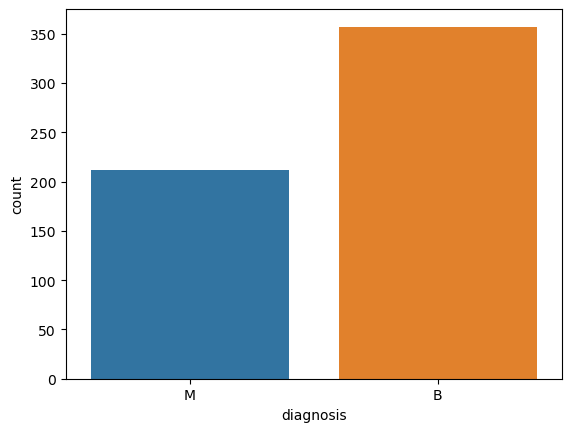

In [12]:
seaborn.countplot(x = 'diagnosis',data = df_cancer)
plt.savefig('cancertot.png')

<Figure size 2500x2500 with 0 Axes>

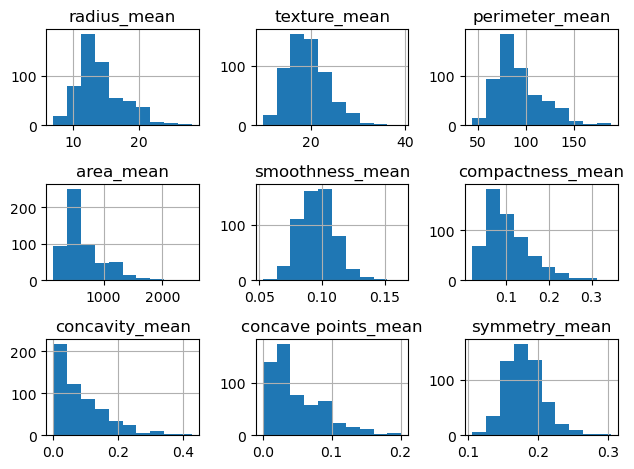

In [14]:
plt.figure(figsize = (25,25))
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_1.png')

<Figure size 2500x2500 with 0 Axes>

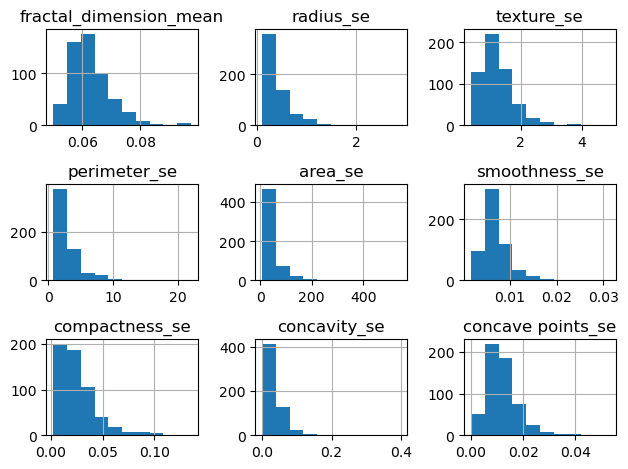

In [15]:
plt.figure(figsize = (25,25))
df_cancer[['fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_2.png')

<Figure size 2500x2500 with 0 Axes>

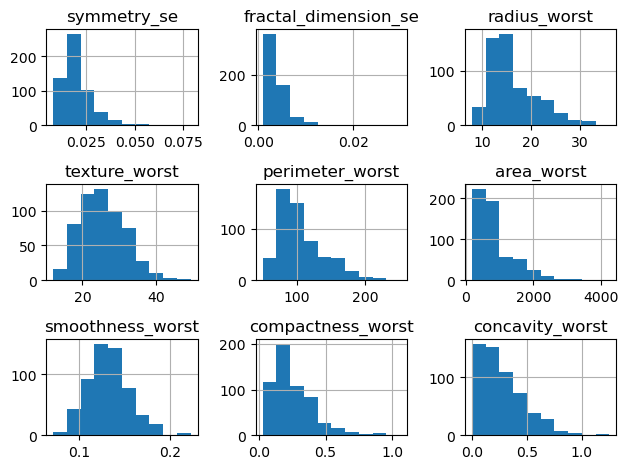

In [277]:
plt.figure(figsize = (25,25))
df_cancer[['symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_3.png')

<Figure size 2500x2500 with 0 Axes>

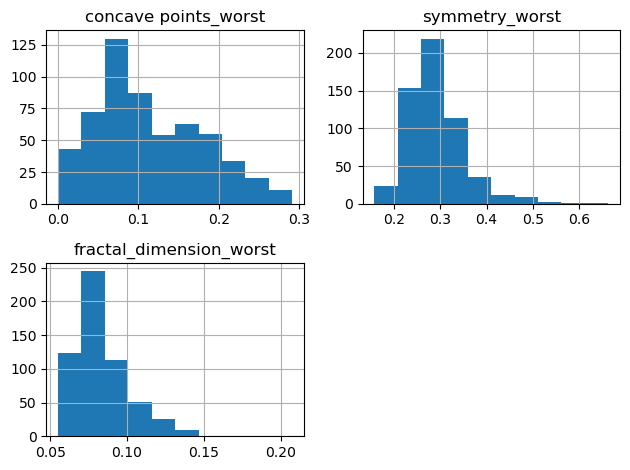

In [279]:
plt.figure(figsize = (25,25))
df_cancer[['concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].hist()
plt.tight_layout()
plt.savefig('hist_cancer_t_4.png')

<Figure size 2500x2500 with 0 Axes>

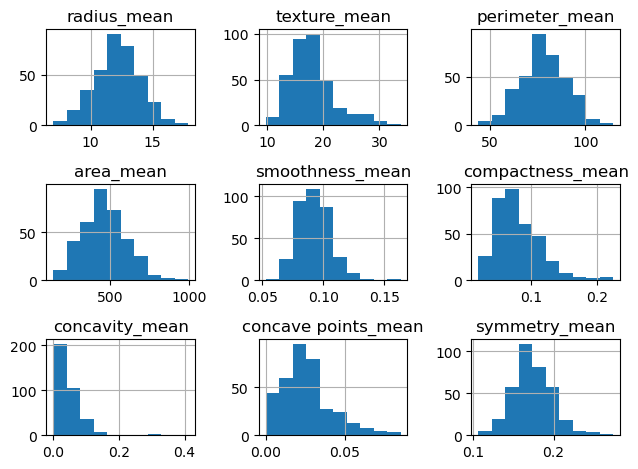

In [280]:
plt.figure(figsize = (25,25))
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_1.png')

<Figure size 2500x2500 with 0 Axes>

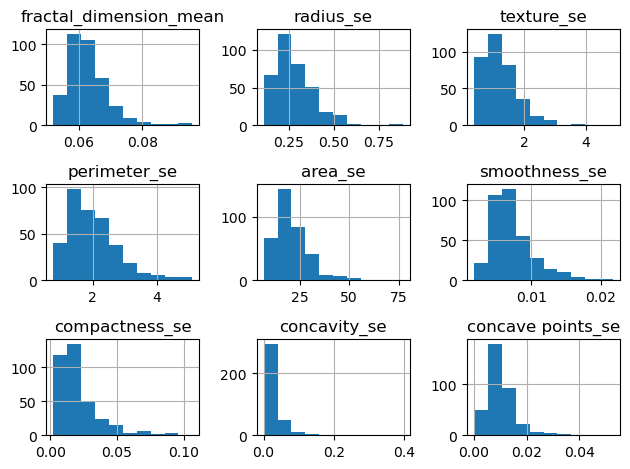

In [281]:
plt.figure(figsize = (25,25))
df_cancer[['fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_2.png')

<Figure size 2500x2500 with 0 Axes>

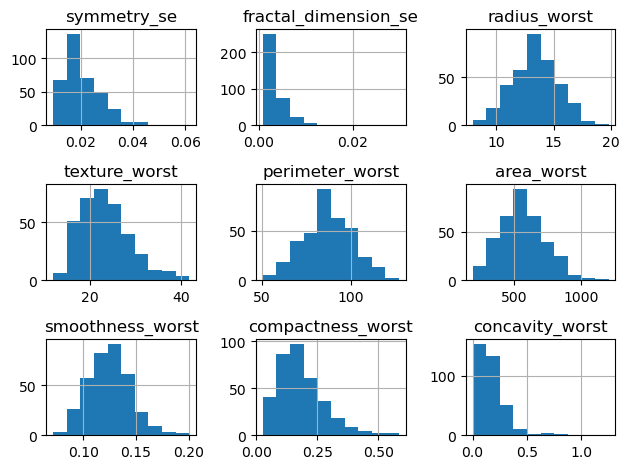

In [282]:
plt.figure(figsize = (25,25))
df_cancer[['symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_3.png')

<Figure size 2500x2500 with 0 Axes>

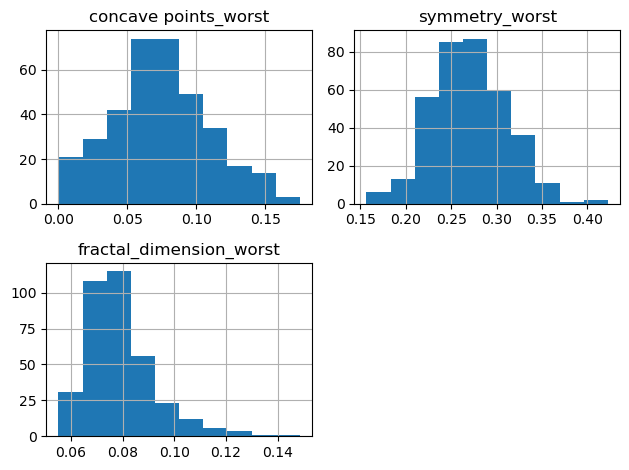

In [283]:
plt.figure(figsize = (25,25))
df_cancer[['concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].loc[df_cancer['diagnosis']=='B'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_no_4.png')

<Figure size 2500x2500 with 0 Axes>

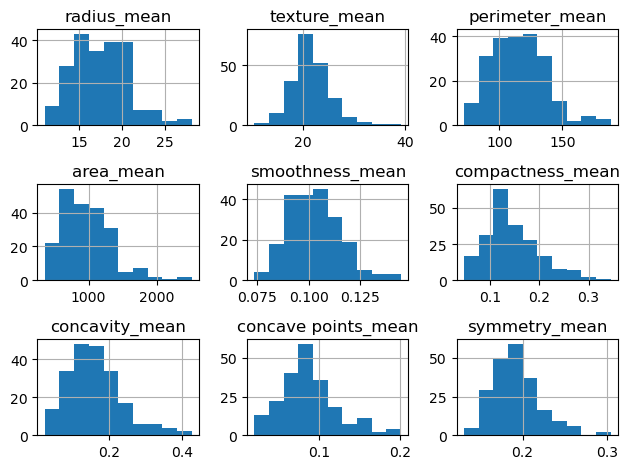

In [284]:
plt.figure(figsize = (25,25))
df_cancer[['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_1.png')

<Figure size 2500x2500 with 0 Axes>

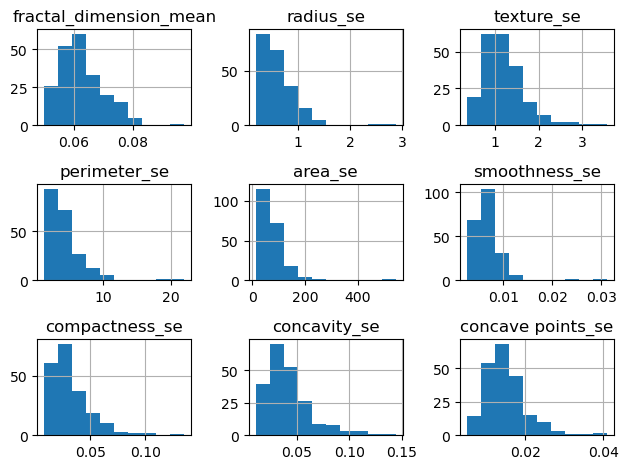

In [285]:
plt.figure(figsize = (25,25))
df_cancer[['fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_2.png')

<Figure size 2500x2500 with 0 Axes>

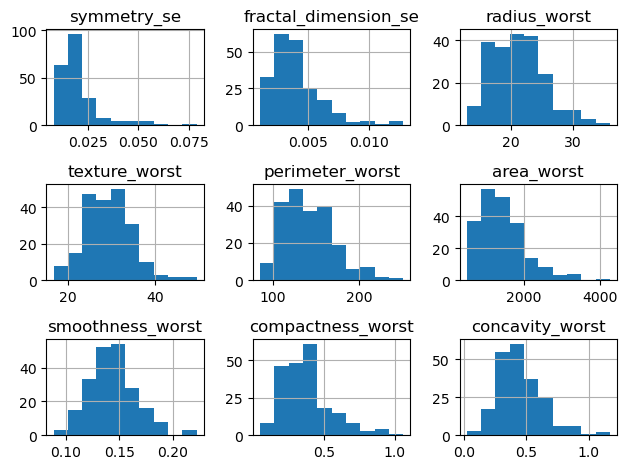

In [286]:
plt.figure(figsize = (25,25))
df_cancer[['symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_3.png')

<Figure size 2500x2500 with 0 Axes>

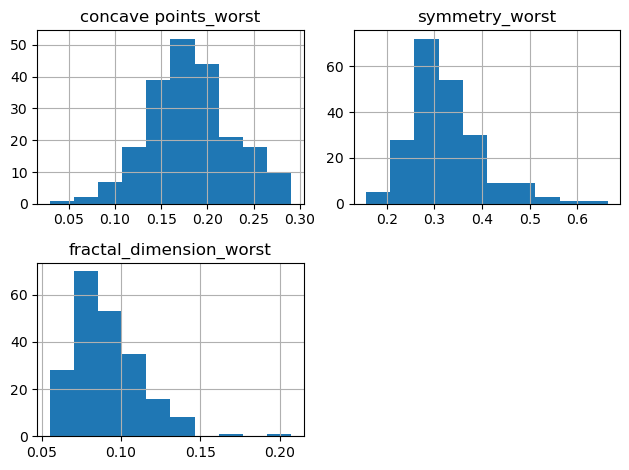

In [287]:
plt.figure(figsize = (25,25))
df_cancer[['concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].loc[df_cancer['diagnosis']=='M'].hist()
plt.tight_layout()
plt.savefig('hist_cancer_yes_4.png')

## XGBoost

In [17]:
df_cancer.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [18]:
df_cancer.loc[df_cancer['diagnosis']=='M','target']=1

In [20]:
df_cancer = df_cancer.fillna(0)

In [22]:
var_cols = df_cancer.drop(columns=['id','diagnosis','target']).columns
var_cols

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [23]:
X = df_cancer.loc[:,var_cols]
y = df_cancer.loc[:,'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((398, 30), (171, 30), (398,), (171,))

In [92]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda': 0.05
}

In [93]:
XGBoost_class = XGBClassifier(**parameters)

In [94]:
start = timeit.default_timer()
XGBoost_model = XGBoost_class.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

0.05206434999990961

In [95]:
y_prob = XGBoost_model.predict(X_test)
auc_logloss_ks(y_test, y_prob)

(0.966931216931217, 1.0099150945579762, 0.9338624338624338)

### XGBoost using optuna

In [1]:
XGBoost_model = train(X_train, y_train, X_test, y_test, balanced='balanced', method='XGBoost')

### CatBoost

In [104]:
parameters = {
        'learning_rate': 0.3,
        'depth': 3,
        'l2_leaf_reg': 0.05
}

In [105]:
CatBoost_Classifier = CatBoostClassifier(**parameters)

In [106]:
# Fit model
start = timeit.default_timer()
CatBoost_model = CatBoost_Classifier.fit(X_train, y_train,verbose=False)
stop = timeit.default_timer()
stop - start

0.8346759369997017

In [107]:
y_prob = CatBoost_model.predict(X_test)
auc_logloss_ks(y_test, y_prob)

(0.9543650793650793, 1.4138820675828392, 0.9087301587301587)

### CatBoost using Optuna

In [124]:
CatBoost_model = train(X_train, y_train, X_test, y_test, balanced='balanced', method='CATBoost')

### LightGBM

In [116]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda_l2': 0.05
}

In [117]:
LGBM_Classifier = LGBMClassifier(**parameters)

In [120]:
start = timeit.default_timer()
LGBM_model = LGBM_Classifier.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

In [119]:
y_prob = LGBM_model.predict(X_test)
auc_logloss_ks(y_test,y_prob)

(0.9510582010582009, 1.4138773915744756, 0.9021164021164021)

### LGBM using Optuna

In [125]:
LGBM_model = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

# SHAP for model with best perfom

In [126]:
explainer = shap.TreeExplainer(XGBoost_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


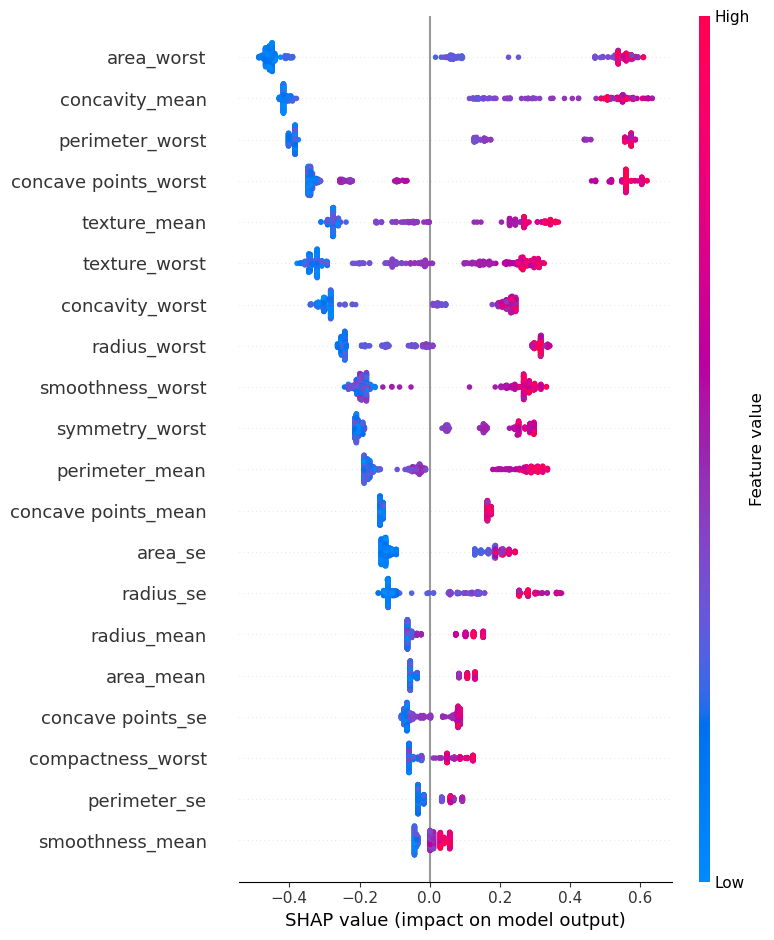

In [127]:
shap.summary_plot(shap_values, X_train,show=False)
plt.savefig('shap_cancer.png')

## Performance Default


|| XGBoost | CatBoost| LGBM |
|---| --- | --- | --- |
AUC| 0.97950|	0.97156|	0.94511 |
logloss| 0.60595|	0.80793	|1.81785|
KS| 0.95899|	0.94312|	0.89021|
time (s)| 0.14904	|2.72823|	0.08682|

## Optuna (1h tuning for each model)


|| XGBoost | CatBoost| LGBM |
|---| --- | --- | --- |
AUC| 0.99927|	0.99927|	0.99912|
logloss| 0.08477|	0.04291|	0.07038|
KS| 0.98413|	0.97487|	0.97487|